# Table of contents
1. [Notebook Setup](#setup)
2. [Dataset Formation](#data-formation)
3. [Data Analysis](#data-analysis)
    1. [Histogram Plots](#histograms)
    2. [Correlation Heatmap](#correlation-heatmap)
    3. [Takeawyas](#takeaways)
4. [Build Pipeline](#pipeline)
5. [Parameter Tuning](#tuning)
    1. [Model Selection](#select)
        1. [Parameter Search](#param)
        2. [Model Search](#model)
    2. [Further Model Tuning](#final-tune)

# Notebook setup <a name="setup"></a>
In this section we import the packages that will be used throughout the projects, and select a random seed.

In [1]:
#Installing pandas
import pandas as pd
#%conda install -c conda-forge pandasql

In [2]:
#Import standard packages
import pandasql as psql
import random as rand

#Data visualisation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## scikit-learn modules:

#starting the pipeline
# preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder, QuantileTransformer, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectFpr, f_classif
from sklearn.impute import SimpleImputer


# model training/tuning
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer


# models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# model validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, make_scorer


# dataframe viewing rows
#pd.set_option('display.max_rows', 100)

In [3]:
#Setting random seed for the notebook
seed_choice = 7
seed = rand.Random(7)

# Dataset Formation <a name="data-formation"></a>
In this section we read in our data from kaggle, clean it and define the feature list.

In [4]:
#reading in .csv file from https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability
water = pd.read_csv('water_potability.csv')

In [5]:
#Defining the feature list for our data. These are the variable that our AI will train on.
feature_list = ['ph', # indicate ph
                'Hardness', # indicates hardness
                'Solids', # indicates solids
                'Chloramines', # indicates Chloramines
                'Sulfate', # indicates Sulfate
                'Conductivity', # indicates Conductivity
                'Organic_carbon', # indicates Organic_carbon
                'Trihalomethanes', # indicates Trihalomethanes
                'Turbidity'] # indicates Turbidity

In [6]:
#remove below comment to view data
#water

In [7]:
#Removing the NaN values for water data (only NaN values were in ph, sulfate and trihalomethanes). Remove last comment to view
waternonan = psql.sqldf('select * from water where ph is not null and Sulfate is not null and Trihalomethanes is not null')
#waternonan

In [8]:
#checking successfull removal of NaN values
check_nan = waternonan['ph' or 'Trihalomethanes' or 'Hardness' or 'Solids' or 'Chloramines' or 'Sulfate' or 'Conductivity' or 'Organic_carbon' or 'Turbidity' or 'Potability'].isnull().sum()
print(check_nan)

0


# Dataset Analysis <a name="data-analysis"></a>
In this section we perform some preliminary analysis on our dataset. We plot each of our variables on a histogram to get a sense of the shape of our data. We also creat the correlation heatmap for our data.

## Histogram plots <a name="histograms"></a> 

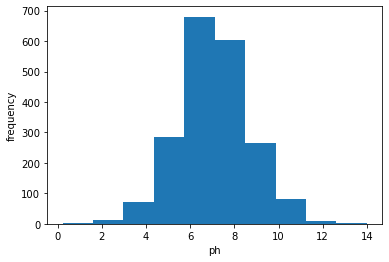

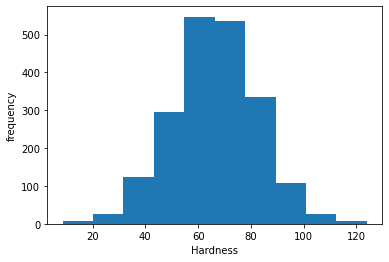

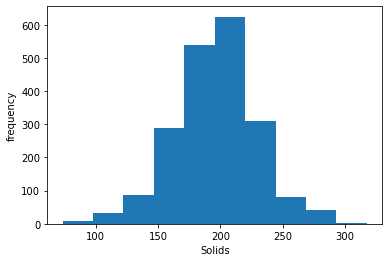

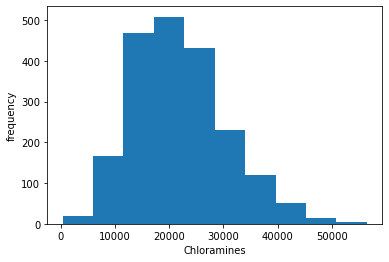

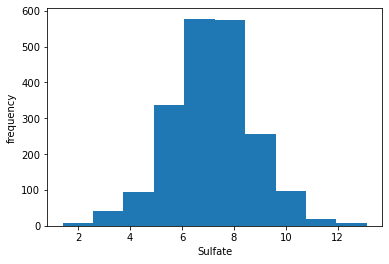

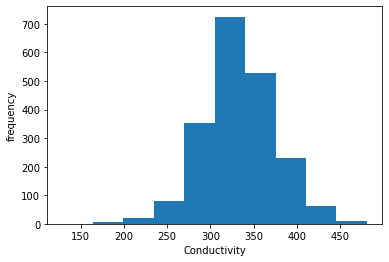

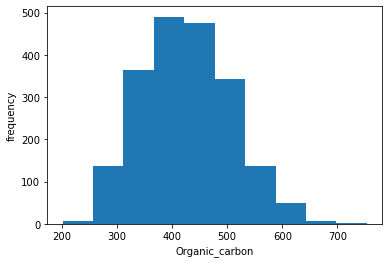

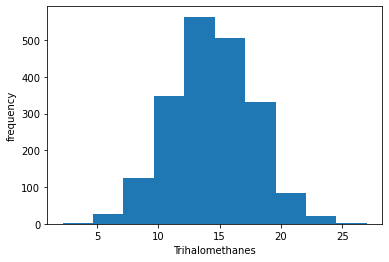

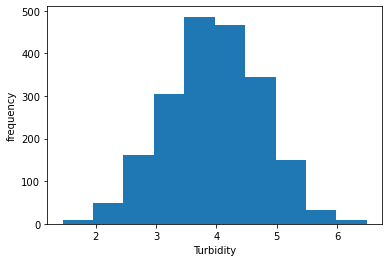

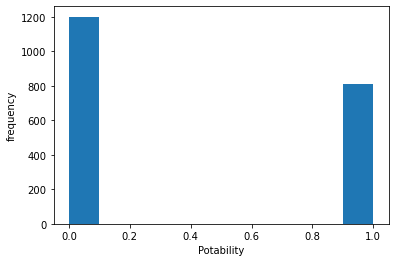

In [9]:
#Plot a histogram of each of the features of our data
i=0
for feature in [waternonan.ph, waternonan.Trihalomethanes, waternonan.Hardness, waternonan.Solids, waternonan.Chloramines, waternonan.Sulfate, waternonan.Conductivity, waternonan.Organic_carbon, waternonan.Turbidity, waternonan.Potability]:
    plt.ylabel('frequency')
    plt.xlabel(waternonan.columns.values[i])
    plt.hist(feature)
    plt.show()
    i += 1

## Corellation Heatmap <a name="correlation-heatmap"></a> 

<AxesSubplot:>

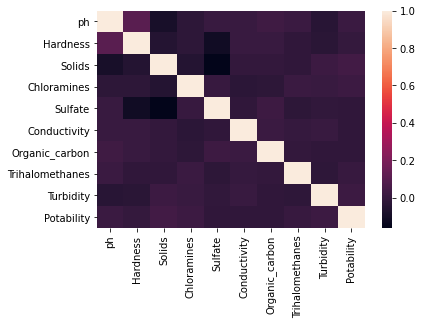

In [10]:
sns.heatmap(waternonan.corr())


## Takeaways <a name="takeaways"></a> 
### Histograms
The features in our data look mor or less normally distributed, so there is no need to logarithmically or exponentially scale any of them. 

We have roughly 2000 data points, with roughly 40% of them being examples of potable water. 
### Corellation Heatmap
Variables and potability are generally uncorrelated. There are no extraneous variables to remove.

# Build Pipeline <a name="pipeline"></a>

In [11]:
# define feature column data, list of features feature_list was defined in data formation
X = waternonan[feature_list].values

# define label column
y = waternonan['Potability'].values

In [12]:
# make 75/25 train/test split, stratified because I have imbalanced label
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed_choice)

In [13]:
# check size of data splits
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1608, 9)
(403, 9)
(1608,)
(403,)


In [14]:
# Define scaler step of pipeline
scaler = Normalizer()

In [15]:
# Define machine learning models

# Logistic Regression:
lr = LogisticRegression(random_state=seed_choice)

# K-nearest Neighbors:
knn = KNeighborsClassifier(n_neighbors=5)

# Naive Bayes:
nb = GaussianNB()

# Random Forest:
rf = RandomForestClassifier(random_state=seed_choice, n_estimators=5, max_depth=10, min_samples_split=10, max_leaf_nodes=13)

# Gradient Boosted Trees:
gb = GradientBoostingClassifier()

# select model to train:
model_name = rf

In [16]:
# define function to get model metrics
def model_metrics(predictions, pipe):
    
    # print summary statistics
    print('Training set score: ' + str(pipe.score(X_train,y_train)))
    print('Test set score: ' + str(pipe.score(X_test,y_test)))
    print(classification_report(y_test, predictions, digits=5))

    # plot confusion matrix
    cm = confusion_matrix(y_test, predictions, normalize='all')
    print(cm)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp_cm.plot()

training model:LogisticRegression(random_state=7)
Training set score: 0.5970149253731343
Test set score: 0.5955334987593052
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       240
           1    0.40150   0.98773   0.57092       163

    accuracy                        0.39950       403
   macro avg    0.20075   0.49387   0.28546       403
weighted avg    0.16239   0.39950   0.23092       403

[[0.         0.5955335 ]
 [0.00496278 0.39950372]]
training model:KNeighborsClassifier()
Training set score: 0.710820895522388
Test set score: 0.5260545905707196
              precision    recall  f1-score   support

           0    0.58974   0.67083   0.62768       240
           1    0.39231   0.31288   0.34812       163

    accuracy                        0.52605       403
   macro avg    0.49103   0.49186   0.48790       403
weighted avg    0.50989   0.52605   0.51461       403

[[0.39950372 0.19602978]
 [0.27791563 0.12655087]]
training 

/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachla

Training set score: 0.664179104477612
Test set score: 0.6451612903225806
              precision    recall  f1-score   support

           0    0.59553   1.00000   0.74650       240
           1    0.00000   0.00000   0.00000       163

    accuracy                        0.59553       403
   macro avg    0.29777   0.50000   0.37325       403
weighted avg    0.35466   0.59553   0.44457       403

[[0.5955335 0.       ]
 [0.4044665 0.       ]]
training model:GradientBoostingClassifier()
Training set score: 0.7941542288557214
Test set score: 0.6401985111662531
              precision    recall  f1-score   support

           0    0.59553   1.00000   0.74650       240
           1    0.00000   0.00000   0.00000       163

    accuracy                        0.59553       403
   macro avg    0.29777   0.50000   0.37325       403
weighted avg    0.35466   0.59553   0.44457       403

[[0.5955335 0.       ]
 [0.4044665 0.       ]]


/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


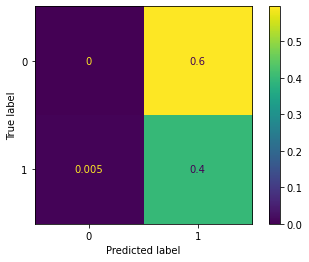

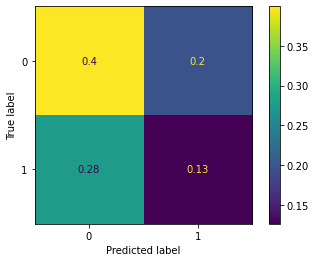

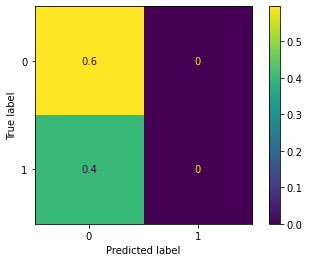

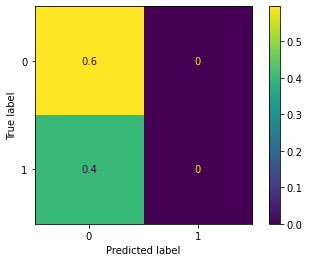

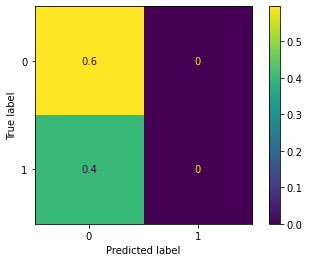

In [17]:
# create loop to test all models with default parameters

model_names = [lr, knn, nb, rf, gb]
for name in model_names:
    print('training model:' + str(name))
    
    # define model name
    model_name = name
    
    # make pipeline steps
    pipe = make_pipeline(scaler,model_name)

    # fit data to model
    pipe.fit(X_train, y_train)

    # save predictions on test set
    predictions = model_name.predict(X_test)

    # print summary statistics
    print('Training set score: ' + str(pipe.score(X_train,y_train)))
    print('Test set score: ' + str(pipe.score(X_test,y_test)))
    print(classification_report(y_test, predictions, digits=5))
#for debugging
#    print(predictions)

    # plot confusion matrix
    cm = confusion_matrix(y_test, predictions, normalize='all')
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

A lot of the models are always predicting undrinkable water. We will try some parameter tuning to see if we can get some of these models to give more reasonable predictions.

## Parameter Tuning <a name="tuning"></a>


## Model Selection <a name="select"></a>

### Parameter Search <a name="param"></a>

Here we do a grid search over the various models and parameters, so see which model is the best, after parameter tuning.

In [18]:
# This is a function I pulled from 
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

# For each hyperparamter it fixes all other parameters to their best values 
# and plots the average score for each value of the hyperparamter.


def plot_search_results(grid):
    
    # Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    # Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    # Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [19]:
# define parameter values (grid) we search over for each model

# Logistic Regression:
lr = LogisticRegression(random_state=seed_choice, solver='liblinear', max_iter=1000)

lr_param_grid = {'logisticregression__penalty': ['l1', 'l2'],
                 'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10]
                }

# K-nearest Neighbors:
knn = KNeighborsClassifier(n_neighbors=10)

knn_param_grid = {'kneighborsclassifier__n_neighbors': [3, 6, 9],
                  'kneighborsclassifier__weights': ['uniform', 'distance'],
                  'kneighborsclassifier__p': [1,2]
                 }

# Naive Bayes:
nb = GaussianNB()
# There are no meaningful paramters to tune for Naive Bayes model so we willl accept the default implementation.

# Random Forest:
rf = RandomForestClassifier(random_state=seed_choice, n_jobs=-1)

rf_param_grid = {'randomforestclassifier__n_estimators': [5, 10, 25, 50, 100],
                 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
                 'randomforestclassifier__max_depth': [3, 5, 10, 16],
                 'randomforestclassifier__max_features': ['sqrt', 'log2', 9],
                 'randomforestclassifier__max_samples': [0.25, 0.5, 0.75, 1]
                }

# Gradient Boosted Trees:
gb = GradientBoostingClassifier(random_state=seed_choice)

gb_param_grid = {'gradientboostingclassifier__n_estimators': [10, 25, 50],
                 'gradientboostingclassifier__loss': ['log_loss', 'exponential'],
                 'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.25, 0.5],
                 'gradientboostingclassifier__subsample': [0.5, 0.75, 1],
                 'gradientboostingclassifier__max_depth': [2, 3, 4, 7],
                 'gradientboostingclassifier__max_features': ['sqrt', 'log2', 9],
                }

In [20]:
# define workflow for training and printing model evaluation metrics, without plotting (for Naive Bayes only)
def train_and_evaluate(scaler,model_name):
    
    # make pipeline steps
    pipe = make_pipeline(scaler,model_name)

    # fit data to model
    pipe.fit(X_train, y_train)

    # save predictions on test set
    predictions = pipe.predict(X_test)

    # display results and metrics
    model_metrics(predictions, pipe)


In [21]:
# define workflow to perform grid search on a model 
#  and print the summary statistics for the best parameters 
#   and plot the results of the cross validation.
def search_train_evaluate_plot(model_name, param_grid, scorer):
    
    # define pipeline
    pipe = make_pipeline(scaler,model_name)

    # define parameter search
    grid_search = GridSearchCV(pipe, param_grid, cv=4, refit = True, verbose = 1, return_train_score=True, scoring=scorer, n_jobs=-1) 

    # train the model on grid search 
    grid_search.fit(X_train, y_train) 

    # print best parameters after tuning 
    print(grid_search.best_params_) 
    best_predictions = grid_search.predict(X_test) 

    # print summary of metrics for best parameters
    model_metrics(best_predictions, grid_search)
    
    # plot results of grid search
    plot_search_results(grid_search)



training model:LogisticRegression(max_iter=1000, random_state=7, solver='liblinear')
Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l1'}
Training set score: 0.5970149253731343
Test set score: 0.5955334987593052
              precision    recall  f1-score   support

           0    0.59553   1.00000   0.74650       240
           1    0.00000   0.00000   0.00000       163

    accuracy                        0.59553       403
   macro avg    0.29777   0.50000   0.37325       403
weighted avg    0.35466   0.59553   0.44457       403

[[0.5955335 0.       ]
 [0.4044665 0.       ]]


/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lachlan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


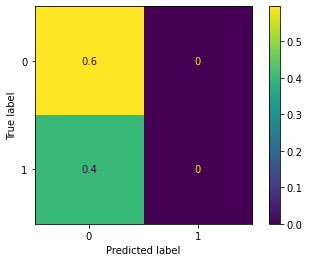

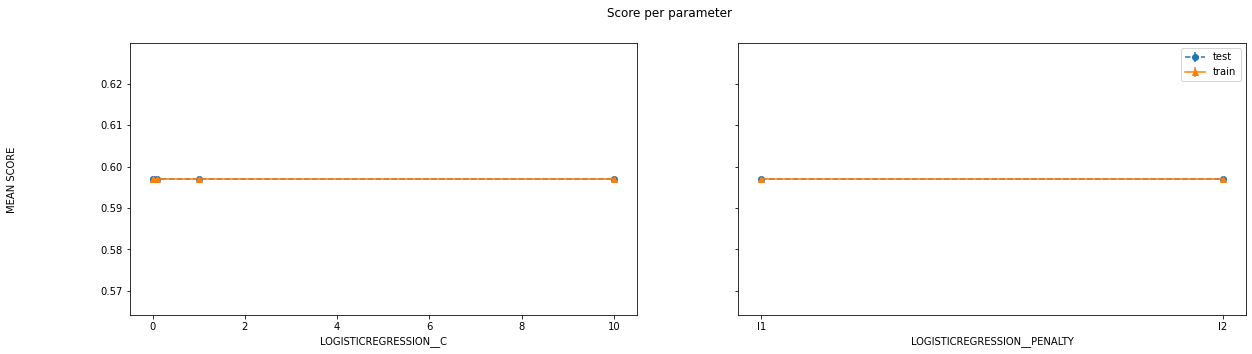

training model:KNeighborsClassifier(n_neighbors=10)
Fitting 4 folds for each of 12 candidates, totalling 48 fits
{'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Training set score: 0.6741293532338308
Test set score: 0.5781637717121588
              precision    recall  f1-score   support

           0    0.60542   0.83750   0.70280       240
           1    0.45070   0.19632   0.27350       163

    accuracy                        0.57816       403
   macro avg    0.52806   0.51691   0.48815       403
weighted avg    0.54284   0.57816   0.52916       403

[[0.49875931 0.09677419]
 [0.32506203 0.07940447]]


KeyboardInterrupt: 

In [45]:
# Conduct grid search over all models and plot results

scorer = make_scorer(accuracy_score)
#scorer = make_scorer(recall_score)

model_and_param_names = [[lr, lr_param_grid], [knn, knn_param_grid], [nb], [rf, rf_param_grid], [gb, gb_param_grid]]
for name in model_and_param_names:
    
    if name[0] == nb:
        
        print('training model:' + str(name[0]))
    
        train_and_evaluate(scaler,name[0])
    else:
        print('training model:' + str(name[0]))

        search_train_evaluate_plot(name[0], name[1], scorer)

Now we analyse the graphs above, taking the best parameters for each model

In [22]:
# define best parameters for each model type

# Logistic Regression:
best_lr = LogisticRegression(random_state=seed_choice, solver='liblinear', max_iter=1000, penalty='l1', C=10)

# K-nearest Neighbors:
best_knn = KNeighborsClassifier(n_neighbors=6, weights='uniform', p=2)

# Naive Bayes:
best_nb = GaussianNB()
# There are no meaningful paramters to tune for Naive Bayes model so we willl accept the default implementation.

# Random Forest:
best_rf = RandomForestClassifier(random_state=seed_choice, criterion='entropy', max_depth=10, max_features=9, max_samples=0.75, n_estimators=100)

# Gradient Boosted Trees:
best_gb = GradientBoostingClassifier(random_state=seed_choice, n_estimators=25, loss='exponential', learning_rate=.1, subsample=1, max_depth=4, max_features=9)



### Model Search <a name="model"></a>

Now that we have found good parameters for each model we run the pipeline once more, using the best parameters and compare them.

In [23]:
# define workflow to perform grid search over model types 
#  and print the summary statistics for the best model 
#   and plot the results of the cross validation.

def model_search_train_evaluate_plot(scorer):
    
    # define model type parameters
    param_grid = [{'classifier': [best_lr]},
                  {'classifier': [best_knn]},
                  {'classifier': [best_nb]},
                  {'classifier': [best_rf]},
                  {'classifier': [best_gb]}
                 ]

    pipe = Pipeline([('scaler', scaler),
                     ('classifier', DummyClassifier())
                    ])
    
    
    
    # define parameter search
    grid_search = GridSearchCV(pipe, param_grid, cv=5, refit = True, verbose = 1, return_train_score=True, scoring=scorer, n_jobs=-1) 

    # train the model on grid search 
    grid_search.fit(X_train, y_train) 

    # print best parameters after tuning 
    print(grid_search.best_params_) 
    best_predictions = grid_search.predict(X_test) 

    # print summary of metrics for best parameters
    #model_metrics(best_predictions, grid_search)
    
    # print score for each fit
    print('mean test scores:' + str(grid_search.cv_results_['mean_test_score']))
    print('mean train scores:' + str(grid_search.cv_results_['mean_train_score']))
    x = np.arange(grid_search.cv_results_['mean_test_score'].shape[0])
    plt.plot(x, grid_search.cv_results_['mean_test_score'], 'bo-')
    plt.plot(x, grid_search.cv_results_['mean_train_score'], 'go-')
    
    plt.show()
    

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'classifier': RandomForestClassifier(criterion='entropy', max_depth=10, max_features=9,
                       max_samples=0.75, random_state=7)}
mean test scores:[0.59701631 0.58705907 0.44896771 0.6486465  0.63558368]
mean train scores:[0.59701501 0.67537463 0.45196903 0.85121559 0.72279452]


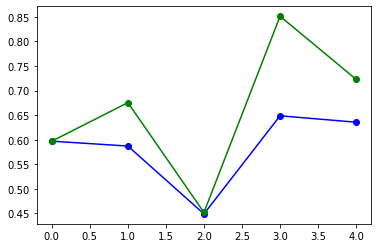

In [24]:
# choose scorer
scorer = make_scorer(accuracy_score)

# search over model types
model_search_train_evaluate_plot(scorer)

The best model is the random forest classifier, so we run the model with the parameters we have found and analyse  its predictions. An argument could be made that the random forest classifier is best, as the lower training score may indicate less overfitting.

## Further Model Tuning <a name="final-tune"></a>

In [41]:
# Defining a finer parameter grid

# Random Forest:
rf = RandomForestClassifier(random_state=seed_choice, n_jobs=-1)

rf_param_grid = {'randomforestclassifier__n_estimators': [60, 75, 90],
                 'randomforestclassifier__criterion': ['gini', 'entropy'],
                 'randomforestclassifier__max_depth': [3, 5, 7],
                 'randomforestclassifier__max_features': [6, 7, 8],
                 'randomforestclassifier__max_samples': [0.75, 0.8, 0.85]
                }

#previous best parameters for reference
#RandomForestClassifier(random_state=seed_choice, criterion='entropy', max_depth=10, max_features=9, max_samples=0.75, n_estimators=100)


Fitting 4 folds for each of 162 candidates, totalling 648 fits
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 8, 'randomforestclassifier__max_samples': 0.85, 'randomforestclassifier__n_estimators': 90}
Training set score: 0.7562189054726368
Test set score: 0.6401985111662531
              precision    recall  f1-score   support

           0    0.63231   0.94583   0.75793       240
           1    0.70455   0.19018   0.29952       163

    accuracy                        0.64020       403
   macro avg    0.66843   0.56801   0.52872       403
weighted avg    0.66153   0.64020   0.57252       403

[[0.56327543 0.03225806]
 [0.32754342 0.07692308]]


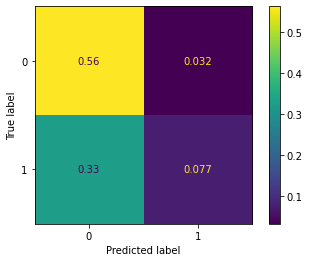

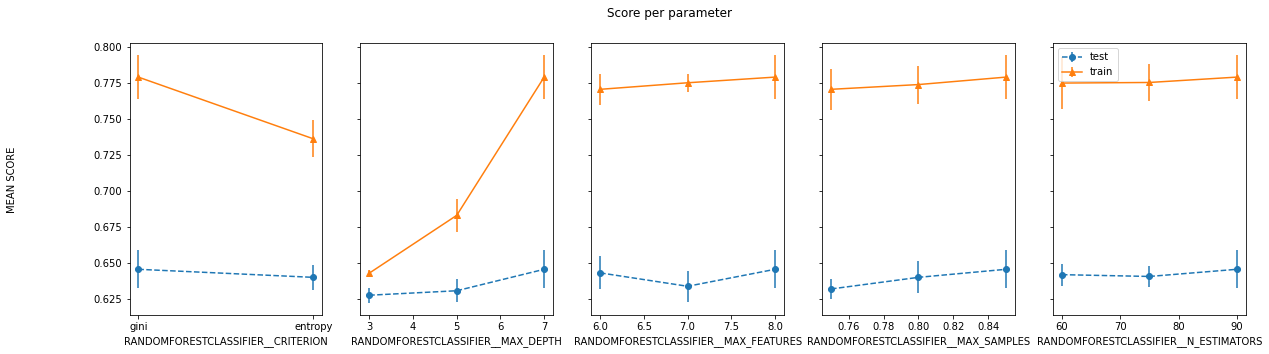

In [42]:
# define names for model
model_name = rf
param_grid = rf_param_grid
scorer = make_scorer(accuracy_score)
#scorer = make_scorer(recall_score)

# run model workflow
search_train_evaluate_plot(model_name, param_grid, scorer)